In [1]:
import numpy as np
import pandas as pd
import torch

import time

from sklearn.datasets import load_iris

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [2]:
%matplotlib inline

In [171]:
class Task:
    def __init__(self, X, y, batch_size, model_fn):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.state = 0
        self.total_batches = len(self.X) // batch_size
        self.model_fn = model_fn
        model = self.model_fn()
        self.model_weights = [model.state_dict(),]
        self.losses = [self.calc_global_loss(model).item()]

    def batch(self, state=-1):
        if state == -1:
            state = self.state
        batch = self.state % self.total_batches
        begin = batch * self.batch_size
        end = (batch + 1) * self.batch_size
        return self.X[begin:end], self.y[begin:end]
    
    def submit_update(self, weights, loss):
        self.state += 1
        self.model_weights.append(weights)
        self.losses.append(loss)

    def set_state(self, state):
        self.state = state
        self.model_weigthts = self.model_weights[:self.state + 1]
        self.losses = self.losses[:self.state + 1]
    
    def model(self, state=-1):
        model = self.model_fn() 
        model.load_state_dict(self.model_weights[state])
        return model


    def calc_global_loss(self, model):
        model.train(False)
        y_pred_global = model(self.X)
        loss_global = criterion(y_pred_global, self.y)
        return loss_global

In [172]:
model_fn = lambda: torch.nn.Sequential(
    torch.nn.Linear(4, 8),
    torch.nn.ReLU(),
    torch.nn.Linear(8, 4))
model_fn()

Sequential(
  (0): Linear(in_features=4, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=4, bias=True)
)

In [173]:
X, y = load_iris(return_X_y=True)
X.shape, y.shape
np.random.seed(0)
idx = np.arange(len(X))
np.random.shuffle(idx)
print(np.mean(idx[:10]))
                        
Xt = torch.Tensor(X[idx])
yt = torch.LongTensor(y[idx]).reshape(-1,1)
Xt[:3], yt[:3]

69.6


(tensor([[5.8000, 2.8000, 5.1000, 2.4000],
         [6.0000, 2.2000, 4.0000, 1.0000],
         [5.5000, 4.2000, 1.4000, 0.2000]]),
 tensor([[2],
         [1],
         [0]]))

In [174]:
def criterion(logits, labels):
    log_softmax = torch.nn.LogSoftmax(dim=1)(logits)
    batch_size = logits.shape[0]
    batch_idx = torch.arange(batch_size).unsqueeze(1)
    return -torch.mean(log_softmax[batch_idx, labels.reshape(-1)])

In [175]:
def compare(model, other_model):
    for t, tt in zip(model.parameters(), other_model.parameters()):
        if not torch.allclose(t, tt, 1e-5):
            return False
    return True

def get_algorithm(model):
    return torch.optim.SGD(model.parameters(), lr=0.01)

In [176]:
def publish_task():
    global task
    torch.manual_seed(42)
    task = Task(Xt, yt, batch_size=32, model_fn=model_fn)

def draw(vals):
    clear_output(wait=True)
    ax.plot(vals)
    ax.set_xlabel('Iter')
    ax.set_ylabel('Loss')
    ax.set_title(f'Model train loss')
    display(fig)
    time.sleep(1)

def worker_make_update(i, malicious=False):
    global task
    assert i == task.state
    x_batch, y_batch = task.batch(i)
    model = task.model()
    print(model)
    y_pred = model(x_batch)
    y_batch_true = y_batch
    if malicious:
        y_batch = torch.zeros_like(y_batch)
    loss = criterion(y_pred, y_batch)
    optimizer = get_algorithm(model)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    weights = model.state_dict()
    loss_global = task.calc_global_loss(model)
    print(loss.item(), loss_global.item(),malicious, y_batch, y_batch_true)
    task.submit_update(model.state_dict(), loss_global.item())
    draw(task.losses)

def frod_proofer_suspect(i):
    pass

def validator_dao_check(i):
    global task
    model_i = task.model(i)
    model_i_next = task.model(i+1)
    x_batch, y_batch = task.batch(i)
    y_pred = model_i(x_batch)
    loss = criterion(y_pred, y_batch)
    optimizer = get_algorithm(model_i)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    is_good = compare(model_i, model_i_next)
    if not is_good:
        task.set_state(i)
    draw(task.losses)

In [177]:
def scenario():
    publish_task()
    worker_make_update(0)
    worker_make_update(1)
    worker_make_update(2, malicious=True)
    worker_make_update(3)
    worker_make_update(4)
    frod_proofer_suspect(2)
    worker_make_update(5)
    validator_dao_check(2)
    worker_make_update(2)
    worker_make_update(3, malicious=True)
    worker_make_update(4)
    worker_make_update(5)
    worker_make_update(6)
    frod_proofer_suspect(3)
    # validators do nothing bc of timeout for disput
    worker_make_update(7)

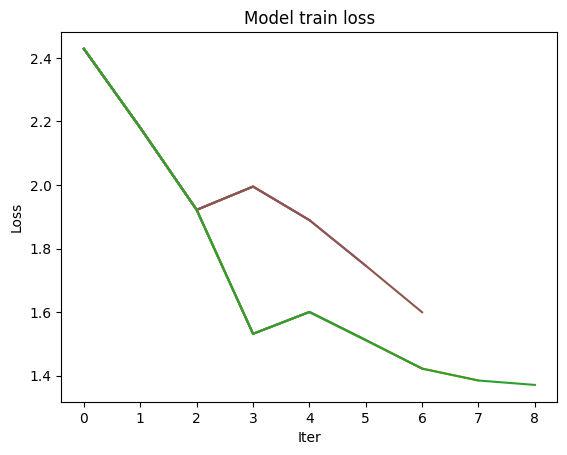

In [178]:
fig, ax = plt.subplots()

scenario()

clear_output(wait=True)